# Import Libraries and functions

In [34]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string

import scipy
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
from tqdm import tqdm
tqdm.pandas()

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [36]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [37]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [38]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https","char","reuters","wall","street","journal","photo"]

In [39]:
def black_txt(token):
    return  token not in stopwords and token not in list(string.punctuation)  and len(token)>3

def clean_txt(text, string = True):
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text = re.sub("\n", "",text)
    text=re.sub("(\\d|\\W)+"," ",text)    
    clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    if string == True:
        return " ".join(clean_text2)
    else:
        return clean_text2

# Load data

In [40]:
#load in data
data = pd.read_csv('clean_data.csv', index_col = 0)

# Build Class Transformers, Pipeline

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

    
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pol':  row['polarity'], 
                 'sub': row['subjectivity'],
                 'n_long_words': row['n_long_words'], 
                 'n_monosyllable_words': row['n_monosyllable_words'], 
                 'n_polysyllable_words': row['n_polysyllable_words'], 
                 'n_unique_words': row['n_unique_words'],
                'topic_0': row['topic_0'],
                'topic_1': row['topic_1'],
                'topic_2': row['topic_2'],
                'topic_3': row['topic_3'],
                'topic_4': row['topic_4'],
                'topic_5': row['topic_5'],
                'topic_6': row['topic_6'],
                'topic_7': row['topic_7'],} for _, row in data.iterrows()]

In [42]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='predictor')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 
                                               'subjectivity', 
                                              'n_long_words',
                                              'n_monosyllable_words',
                                              'n_polysyllable_words',
                                              'n_unique_words',
                                              'topic_0',
                                              'topic_1',
                                              'topic_2',
                                              'topic_3',
                                              'topic_4',
                                              'topic_5',
                                              'topic_6',
                                              'topic_7',])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
])

In [43]:
scaler = MinMaxScaler()

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
seed = 40
X = data[['predictor', 'polarity', 'subjectivity','n_long_words','n_monosyllable_words',
         'n_polysyllable_words','n_unique_words','topic_0','topic_1','topic_2','topic_3',
         'topic_4','topic_5','topic_6','topic_7']]

X[['polarity']] = scaler.fit_transform(X[['polarity']])

y =data['target']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

<ipython-input-44-c6f2a02ed1ef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['polarity']] = scaler.fit_transform(X[['polarity']])
/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [45]:
pipeline.fit(x_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='predictor')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               10),
                                                                                  preprocessor=<function clean_txt at 0x182c2bd30>,
                                                                                  smooth_idf=1,
                                                      

In [46]:
%%time
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the number of features in train and test correspond: (14241, 1947257) - (3561, 1947257)
CPU times: user 2min 19s, sys: 1.38 s, total: 2min 21s
Wall time: 2min 22s


# Test different models

In [47]:
results = pd.DataFrame(columns = ['model','accuracy'])
results

,model,accuracy


In [48]:
#Dummy Classifier
from sklearn.dummy import DummyClassifier
X = data['predictor']
y = data['target']

dummy_cf = DummyClassifier(strategy='stratified')
dummy_cf.fit(X,y)
y_preds = dummy_cf.predict(X)

accuracy = dummy_cf.score(X,y)


In [49]:
new_row = {'model': 'Dummy', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.338052


In [50]:
#Linear Support Vector Machines
sv_clf = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40,verbose=3) 
sv_clf.fit(train_vec, y_train)
test_preds = sv_clf.predict(test_vec)

[LibLinear]

In [51]:
accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'SVM', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.338052
1,SVM,0.943836


In [52]:
#Random Forest
rfc_clf = RandomForestClassifier(n_estimators=200,random_state=0,n_jobs=-1,verbose=1)
rfc_clf.fit(train_vec, y_train)
test_preds = rfc_clf.predict(test_vec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.8s finished


In [53]:
accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'RFC', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.338052
1,SVM,0.943836
2,RFC,0.898624


**MNB**

In [54]:
#Multinomial Bayes
mnb_lemma = MultinomialNB()
mnb_lemma.fit(train_vec, y_train)
test_preds = mnb_lemma.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'MNB', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.338052
1,SVM,0.943836
2,RFC,0.898624
3,MNB,0.652626


**Test out Word2Vec**

In [55]:
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [56]:
X = data['predictor']
y =data['target']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [57]:
embeddings_pipeline = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", RandomForestClassifier(random_state=0,n_jobs=-1, verbose=1)),
    ]
)
embeddings_pipeline.fit(x_train, y_train)
y_pred = embeddings_pipeline.predict(x_test)
cr = classification_report(y_test, y_pred,output_dict=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [58]:
accuracy = accuracy_score(y_test, y_pred)

new_row = {'model': 'word2vec', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.338052
1,SVM,0.943836
2,RFC,0.898624
3,MNB,0.652626
4,word2vec,0.858467


**PAC**

In [59]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [60]:
#Random Forest
pac_clf = PassiveAggressiveClassifier()
pac_clf.fit(train_vec, y_train)
test_preds = pac_clf.predict(test_vec)

In [61]:
accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'PAC', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.338052
1,SVM,0.943836
2,RFC,0.898624
3,MNB,0.652626
4,word2vec,0.858467
5,PAC,0.944678


**Deep Learning, Spacy**

In [116]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [117]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

In [118]:
from sklearn.model_selection import train_test_split
import time
X = data['predictor']
y =data['target']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
Y = np_utils.to_categorical(y)
##Create the tf-idf vector
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = None, preprocessor=clean_txt)

In [119]:
seed = 40
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify =y)
vectorizer.fit(x_train)

TfidfVectorizer(max_df=0.2, min_df=3,
                preprocessor=<function clean_txt at 0x12a829280>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [120]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()
 
def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_train]
print(X_train_sequences[0])

[12582, 4185, 20462, 6811, 7653, 10753, 835, 7611, 23400, 7852, 1812, 20201, 20773, 18193, 20462, 21193, 13810, 4775, 6811, 16440, 23754, 12600, 23965, 6811, 13810, 120, 6010, 6811, 3857, 21923, 12582, 15138, 19238, 120, 19732, 1651, 15720, 2615, 6588, 20773, 1741, 12692, 4935, 22590, 20489, 2960, 20462, 14797, 19882, 23755, 2452, 13985, 1623, 7136, 21370, 19732, 12582, 20462, 18193, 17260, 19157, 11688, 14172, 14976, 18739, 1624, 20056, 6269, 14520, 21876, 1347, 2259, 16719, 19402, 19848, 15392, 20462, 20997, 21017, 23408, 12405, 21583, 20997, 12582, 21999, 15134, 1623, 20462, 6166, 15110, 5267, 8608, 876, 1623, 6269, 16440, 22278, 15132, 7620, 14520, 12330, 11463, 23456, 20201, 15186, 5775, 6716, 8475, 16947, 4065, 385, 7336, 19765, 13810, 120, 10235, 20462, 21193, 15136, 7696, 16130, 9368, 13897, 10213, 12814, 15132, 6811, 21999, 18195, 23889, 20773, 835, 4066, 19612, 20773, 19963, 8481, 9608, 17560, 838, 12654, 19731, 21999, 20773, 1741, 11685, 16093, 1598, 17054, 16316, 12457, 225

In [121]:
# Compute the max lenght of a text

MAX_SEQ_LENGHT=60

N_FEATURES = len(vectorizer.get_feature_names())
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

[12457 22590 21657 20462 10424 15785 20083 14644  6811 21999 20926  1677
 13102 16440   120 20997 12582  2439 23965 12407 18195 11214 20773 17685
   835  4066 13431 16439 23072  5377 23578 20117  7656 11095 12582 22588
 13810 21884 23544  5177 20462 13212 19402 19396  9332 18195  1732  4499
  5703  2994 19238 21370 19732  4066 20462 21193  7136  4148  8475  1276]


In [122]:
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_test]
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [123]:
EMBEDDINGS_LEN = 300

embeddings_index = np.zeros((len(vectorizer.get_feature_names()) + 1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
    try:
        embedding = nlp.vocab[word].vector
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [124]:
model = Sequential()
model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(300, dropout=0.2))
model.add(Dense(len(set(y)), activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 300)           7237800   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 3)                 903       
Total params: 7,959,903
Trainable params: 722,103
Non-trainable params: 7,237,800
_________________________________________________________________
None


In [125]:
model.fit(X_train_sequences, y_train, 
          epochs=5, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate(X_test_sequences, y_test, verbose=1)
print("Accuracy:", scores[1])  #
list_result.append(("LSTM Simple", scores[1]))


Epoch 1/5
73/73 [==============================] - 18s 251ms/step - loss: 1.0992 - accuracy: 0.3327 - val_loss: 1.0995 - val_accuracy: 0.3230
Epoch 2/5
73/73 [==============================] - 19s 259ms/step - loss: 1.0988 - accuracy: 0.3267 - val_loss: 1.0996 - val_accuracy: 0.3230
Epoch 3/5
73/73 [==============================] - 18s 251ms/step - loss: 1.0987 - accuracy: 0.3385 - val_loss: 1.0994 - val_accuracy: 0.3142
Epoch 4/5
73/73 [==============================] - 18s 251ms/step - loss: 1.0987 - accuracy: 0.3274 - val_loss: 1.0993 - val_accuracy: 0.3230
Epoch 5/5
81/81 [==============================] - 3s 38ms/step - loss: 1.0986 - accuracy: 0.3331
Accuracy: 0.3330739438533783


**LSTM with new features**

In [126]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(2,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((LSTM(300, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 300)      7237800     text[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 300)          721200      embedding_1[0][0]                
__________________________________________________________________________________________________
meta (InputLayer)               [(None, 2)]          0                                            
_______________________________________________________________________________________

In [127]:
df_cat_train = data.iloc[x_train.index][['polarity', 'subjectivity']]
df_cat_test = data.iloc[x_test.index][['polarity', 'subjectivity']]

In [128]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=12, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  
list_result.append(("LSTM with Multi-Input", scores[1]))

Epoch 1/12
73/73 [==============================] - 27s 373ms/step - loss: 1.0504 - accuracy: 0.4277 - val_loss: 1.0891 - val_accuracy: 0.3920
Epoch 2/12
73/73 [==============================] - 27s 376ms/step - loss: 1.0220 - accuracy: 0.4496 - val_loss: 1.0866 - val_accuracy: 0.3580
Epoch 3/12
73/73 [==============================] - 28s 377ms/step - loss: 1.0145 - accuracy: 0.4619 - val_loss: 1.0807 - val_accuracy: 0.3716
Epoch 4/12
73/73 [==============================] - 28s 379ms/step - loss: 1.0133 - accuracy: 0.4587 - val_loss: 1.0703 - val_accuracy: 0.3901
Epoch 5/12
73/73 [==============================] - 28s 378ms/step - loss: 1.0109 - accuracy: 0.4613 - val_loss: 1.0584 - val_accuracy: 0.4008
Epoch 6/12
73/73 [==============================] - 28s 382ms/step - loss: 1.0105 - accuracy: 0.4666 - val_loss: 1.0425 - val_accuracy: 0.4621
Epoch 7/12
73/73 [==============================] - 28s 387ms/step - loss: 1.0089 - accuracy: 0.4671 - val_loss: 1.0307 - val_accuracy: 0.4446

**EDA**

In [504]:
%%time
vectorizer = TfidfVectorizer(max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(data.predictor)

CPU times: user 1min 9s, sys: 251 ms, total: 1min 9s
Wall time: 1min 9s


TfidfVectorizer(preprocessor=<function clean_txt at 0x3091c7a60>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [507]:
def create_tf_matrix(target):
    return vectorizer.transform(data[data.target == target].predictor)

def create_term_freq(matrix, cat):
    category_words = matrix.sum(axis=0)
    category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in data.target.unique():
    print("Top 20 terms for: ", cat)
    df_right = create_term_freq(create_tf_matrix(cat), cat).head(20)
    print(df_right)
    print("###############")
    if cat != 'right':
        df_top20_words = df_top20_words.merge(df_right, how='outer')
    else:
        df_top20_words = df_right.copy()
    
    print(df_top20_words.shape )

Top 20 terms for:  right
          Terms       right
0         error  341.955357
1   coronavirus  152.125348
2         trump   96.729464
3         state   87.905622
4          news   80.307054
5     president   77.830787
6        people   77.795992
7          case   73.346859
8          test   73.073659
9         virus   71.842426
10        china   70.950255
11        covid   69.923345
12     pandemic   69.208199
13         time   68.594806
14       health   65.140937
15        would   64.338881
16       report   64.128585
17         also   55.902414
18         take   53.803893
19         make   53.570926
###############
(20, 2)
Top 20 terms for:  left
          Terms        left
0         trump  141.425209
1   coronavirus  130.990484
2        people  114.791168
3         state  112.088285
4         covid  108.363883
5          test  107.581531
6     president  104.928598
7        health  103.477712
8          case  102.206863
9         virus   92.095153
10     pandemic   91.727885
11 

In [508]:
df_top20_words.fillna(0, inplace=True )
df_top20_words.set_index('Terms', inplace=True)
df_top20_words.shape

(34, 3)

In [509]:
# !pip install textacy

In [510]:

import numpy as np
from textacy.viz.termite import draw_termite_plot

In [511]:
df = df_top20_words.copy()
df_norm = (df) / (df.max() - df.min())


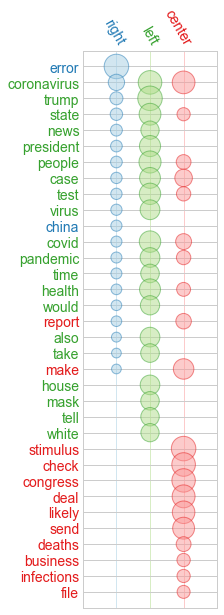

In [512]:
draw_termite_plot(np.array(df_norm.values),df_top20_words.columns,df_top20_words.index,highlight_cols=[0,1,2])


In [385]:
data.head()

,source,author,title,publishedAt,content,target,month,full_text,predictor,pred_len,polarity,subjectivity
0,fox-news,David Aaro,Washington state choir practice deemed coronav...,2020-05-13 07:13:05+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,Washington state choir practice deemed coronav...,0.096397,0.053571,0.396791
1,fox-news,Christopher Carbone,Why are children less affected by coronavirus?,2020-04-28 19:32:02+00:00,Get all the latest news on coronavirus and mor...,right,4.0,Get all the latest news on coronavirus and mor...,Why are children less affected by coronavirus?...,0.069980,0.143564,0.516429
2,fox-news,Stephanie Nolasco,Queen Elizabeth's coronavirus address 'will of...,2020-04-05 15:15:37+00:00,Get all the latest news on coronavirus and mor...,right,4.0,Get all the latest news on coronavirus and mor...,Queen Elizabeth's coronavirus address 'will of...,0.176065,0.124977,0.520614
3,fox-news,Chris Ciaccia,Potential coronavirus vaccine moves step close...,2020-05-07 12:45:51+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,Potential coronavirus vaccine moves step close...,0.077191,0.180781,0.513058
4,fox-news,Christopher Carbone,Coronavirus testing shortfall in crisis-affect...,2020-05-22 05:00:06+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,Coronavirus testing shortfall in crisis-affect...,0.070519,0.058899,0.402898


**Sentiment by Target**

In [513]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [514]:
data.head()

,source,author,title,publishedAt,content,target,month,full_text,predictor,Stats,n_long_words,n_monosyllable_words,n_polysyllable_words,n_unique_words,polarity,subjectivity
0,fox-news,David Aaro,Washington state choir practice deemed coronav...,2020-05-13 07:13:05+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,Washington state choir practice deemed coronav...,"{'n_chars': 3228, 'n_long_words': 178, 'n_mono...",0.288493,0.632091,0.155592,0.502431,0.053571,0.396791
1,fox-news,Christopher Carbone,Why are children less affected by coronavirus?,2020-04-28 19:32:02+00:00,Get all the latest news on coronavirus and mor...,right,4.0,Get all the latest news on coronavirus and mor...,Why are children less affected by coronavirus?...,"{'n_chars': 2321, 'n_long_words': 126, 'n_mono...",0.261411,0.676349,0.120332,0.535270,0.143564,0.516429
2,fox-news,Stephanie Nolasco,Queen Elizabeth's coronavirus address 'will of...,2020-04-05 15:15:37+00:00,Get all the latest news on coronavirus and mor...,right,4.0,Get all the latest news on coronavirus and mor...,Queen Elizabeth's coronavirus address 'will of...,"{'n_chars': 5783, 'n_long_words': 300, 'n_mono...",0.249584,0.688852,0.118968,0.417637,0.124977,0.520614
3,fox-news,Chris Ciaccia,Potential coronavirus vaccine moves step close...,2020-05-07 12:45:51+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,Potential coronavirus vaccine moves step close...,"{'n_chars': 2576, 'n_long_words': 144, 'n_mono...",0.277992,0.652510,0.150579,0.542471,0.180781,0.513058
4,fox-news,Christopher Carbone,Coronavirus testing shortfall in crisis-affect...,2020-05-22 05:00:06+00:00,Get all the latest news on coronavirus and mor...,right,5.0,Get all the latest news on coronavirus and mor...,Coronavirus testing shortfall in crisis-affect...,"{'n_chars': 2372, 'n_long_words': 142, 'n_mono...",0.314159,0.639381,0.134956,0.557522,0.058899,0.402898


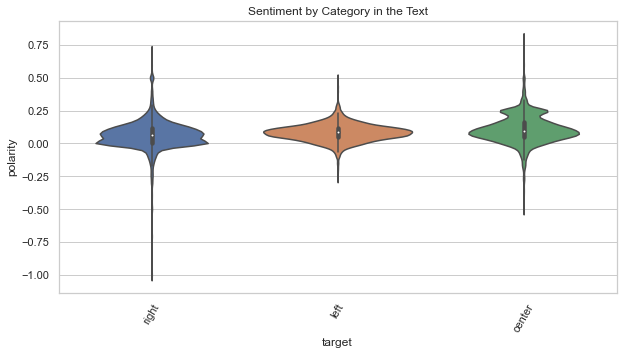

In [515]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="polarity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="polarity", data=data, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

**Objectivity by Target**

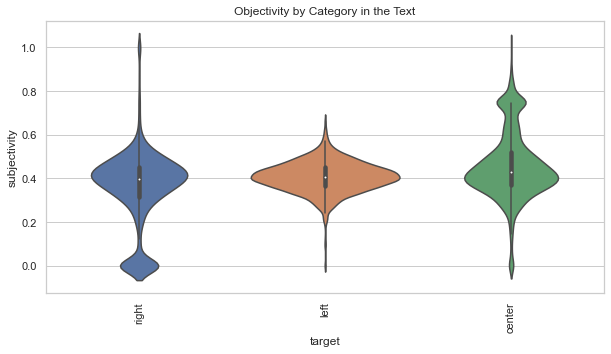

In [516]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="subjectivity", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Objectivity by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**n_long_words by target**

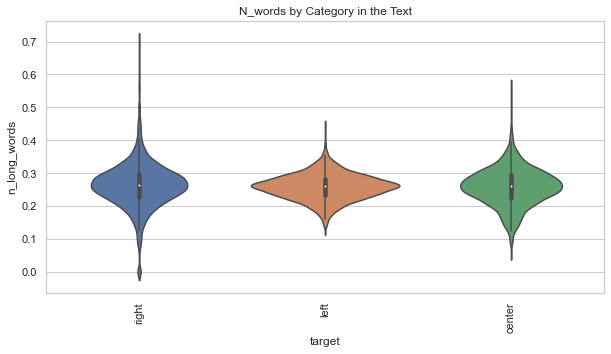

In [517]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_long_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**n_monosyllable_words by target**

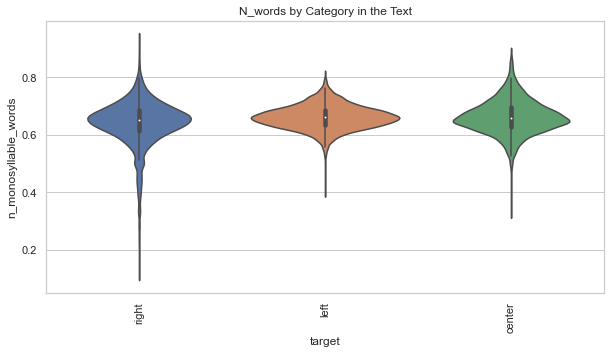

In [518]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_monosyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**n_polysyllable_words by target**

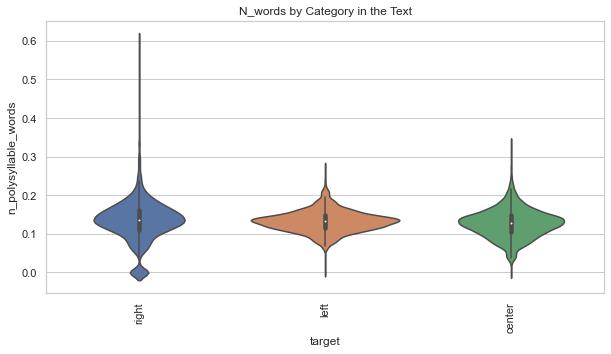

In [519]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_polysyllable_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

**n_unique_words by target**

In [ ]:
plt.figure(figsize=(10,5))
ax = sns.violinplot(x="target", y="n_unique_words", data=data, showfliers=False)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('N_words by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
data.groupby(by=['month','target'])['polarity'].mean().unstack().plot()

In [ ]:
data.groupby(by=['month','target'])['subjectivity'].mean().unstack().plot()